<a href="https://colab.research.google.com/github/LuluW8071/Brain-Tumor-Detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.1.0+cu121
cuda


In [2]:
!nvidia-smi

Wed Mar  6 08:06:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Get Data

#### [Download Datasets](https://drive.google.com/file/d/1YM2PalzV_zqtxfbZNutvRkXgIrxtvoyb/view?usp=drive_link)


In [3]:
try:
  import rarfile
except:
  !pip install rarfile

In [4]:
import gdown
import rarfile
import os

file_url = 'https://drive.google.com/uc?id=1YM2PalzV_zqtxfbZNutvRkXgIrxtvoyb'
file_name = 'brain_tumor_dataset.rar'

# Download the file from Google Drive
gdown.download(file_url, file_name, quiet=False)
extract_dir = './'

# Extract the rar file
with rarfile.RarFile(file_name, 'r') as rar_ref:
    rar_ref.extractall(extract_dir)

# Remove the rar file after extraction
os.remove(file_name)
print("Files extracted successfully to:", extract_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1YM2PalzV_zqtxfbZNutvRkXgIrxtvoyb
From (redirected): https://drive.google.com/uc?id=1YM2PalzV_zqtxfbZNutvRkXgIrxtvoyb&confirm=t&uuid=48e244d6-4c65-4622-aaf7-0d203709b3e5
To: /content/brain_tumor_dataset.rar
100%|██████████| 190M/190M [00:02<00:00, 91.7MB/s]


Files extracted successfully to: ./


In [10]:
from pathlib import Path
import os

# Setup path to data folder
image_path = Path("/content/Brain_Tumor_Datasets")

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in '/content/Brain_Tumor_Datasets'.
There are 2 directories and 0 images in '/content/Brain_Tumor_Datasets/train'.
There are 0 directories and 2869 images in '/content/Brain_Tumor_Datasets/train/no'.
There are 0 directories and 4143 images in '/content/Brain_Tumor_Datasets/train/yes'.
There are 2 directories and 0 images in '/content/Brain_Tumor_Datasets/test'.
There are 0 directories and 717 images in '/content/Brain_Tumor_Datasets/test/no'.
There are 0 directories and 1035 images in '/content/Brain_Tumor_Datasets/test/yes'.


## 2. Data Preparation (Visualization)

Random image path: /content/Brain_Tumor_Datasets/train/yes/Tr-pi_0612.jpg
Image Class: yes
Image Height: 512
Image Width: 512


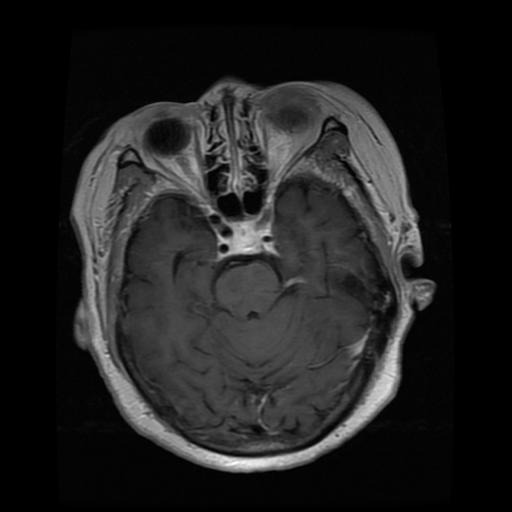

In [15]:
import random
from PIL import Image

# random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg"))
# print(len(image_path_list))
random_image_path = random.choice(image_path_list)
# print(random_image_path)
# the image class is the name of the directory where iamges resides
image_class = random_image_path.parent.stem
# print(image_class)

img = Image.open(random_image_path)

# Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image Class: {image_class}')
print(f'Image Height: {img.height}')
print(f'Image Width: {img.width}')
img

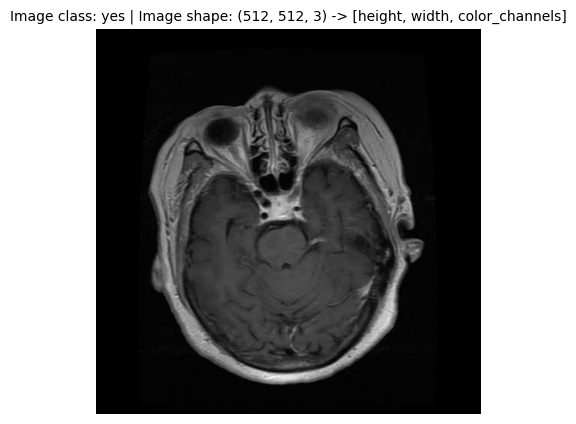

In [16]:
# Visualizing using matplotliib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
fig = plt.figure(figsize=(6, 5))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]", fontsize = 10)
plt.axis(False)
plt.show()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
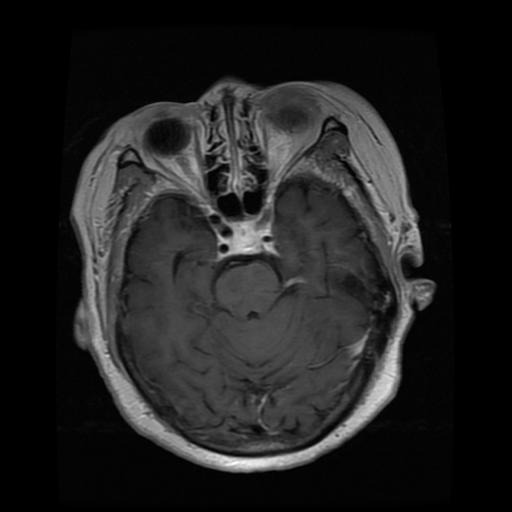

In [17]:
img_as_array

## 3. Transforming data

In [18]:
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

print(torchvision.__version__)

# Transform image
data_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),         # Resize our images to 224x224
    transforms.Grayscale(num_output_channels=1),  # Convert image to grayscale
    transforms.ToTensor()
])


transformed_data = data_transform(img)
transformed_data, transformed_data.shape, transformed_data.dtype

0.16.0+cu121


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 torch.Size([1, 224, 224]),
 torch.float32)

## 4. Loading data with `ImageFolder`

In [21]:
# Setup train and test paths
train_dir = 'Brain_Tumor_Datasets/train'
test_dir = 'Brain_Tumor_Datasets/test'

train_dir, test_dir

('Brain_Tumor_Datasets/train', 'Brain_Tumor_Datasets/test')

In [22]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, # Transforms input data into tensors
                                  target_transform = None)  # Transform labels into none

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 7012
     Root location: Brain_Tumor_Datasets/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                Grayscale(num_output_channels=1)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1752
     Root location: Brain_Tumor_Datasets/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                Grayscale(num_output_channels=1)
                ToTensor()
            ))

In [23]:
# Get class names as lists
class_names = train_data.classes
class_names

['no', 'yes']

In [24]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'no': 0, 'yes': 1}

In [25]:
train_data.samples[:4000:500]

[('Brain_Tumor_Datasets/train/no/1 no.jpeg', 0),
 ('Brain_Tumor_Datasets/train/no/Tr-no_0145.jpg', 0),
 ('Brain_Tumor_Datasets/train/no/Tr-no_0776.jpg', 0),
 ('Brain_Tumor_Datasets/train/no/Tr-no_1402.jpg', 0),
 ('Brain_Tumor_Datasets/train/no/no1369.jpg', 0),
 ('Brain_Tumor_Datasets/train/no/no591.jpg', 0),
 ('Brain_Tumor_Datasets/train/yes/Te-gl_0161.jpg', 1),
 ('Brain_Tumor_Datasets/train/yes/Te-pi_0181.jpg', 1)]

In [26]:
# Index on the train_data Dataset to get a single iamge and label
img, label = train_data[0][0], train_data[0][1]

img, img.dtype, label, type(label), class_names[label]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 torch.float32,
 0,
 int,
 'no')

In [27]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)
img.shape, img_permute.shape

(torch.Size([1, 224, 224]), torch.Size([224, 224, 1]))

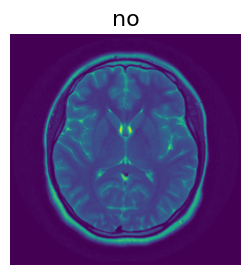

In [28]:
# Plot the image
plt.figure(figsize = (3, 3))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize = 16);

## 5. Turn loaded images into `Dataloaders`

In [29]:
# Train and test dataloaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = 1,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             num_workers = 1,
                             shuffle = False)

len(train_dataloader), len(test_dataloader)

(220, 55)

In [30]:
img, label = next(iter(train_dataloader))

img.shape, label.shape     # {img.shape} -> [batch_size, color_channels, height, width]

(torch.Size([32, 1, 224, 224]), torch.Size([32]))

## 6. Build Model from scratch using `VGG` as Base Model

<img src = "https://miro.medium.com/v2/resize:fit:850/1*B_ZaaaBg2njhp8SThjCufA.png">

In [31]:
class BrainTumorVGGModel(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super(BrainTumorVGGModel, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(hidden_units),
            nn.Dropout(0.2)  # Dropout for regularization
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(4 * hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(4 * hidden_units),
            # nn.Dropout(0.2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(4 * hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(4 * hidden_units, 2 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(2 * hidden_units),
            nn.Dropout(0.2)
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(2 * hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, output_shape, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(output_shape),
            # nn.Dropout(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(392, hidden_units),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.classifier(x)
        return x

In [32]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

In [33]:
from torchinfo import summary

# Instance of Improved TinyVGG
model = BrainTumorVGGModel(1, 64, len(class_names)).to(device)   # (input_shape, hidden_units, output_shape)
summary(model, input_size = [1, 1, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
BrainTumorVGGModel                       [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         640
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─BatchNorm2d: 2-6                  [1, 64, 112, 112]         128
│    └─Dropout: 2-7                      [1, 64, 112, 112]         --
├─Sequential: 1-2                        [1, 256, 56, 56]          --
│    └─Conv2d: 2-8                       [1, 256, 112, 112]        147,712
│    └─ReLU: 2-9                         [1, 256, 112, 112]        --
│    └─Conv2d: 2-10                      [1, 256, 112, 112]        590,080

In [34]:
# Trying forward pass to check the model
model(img.to(device))

tensor([[ 0.1341, -0.0195],
        [-0.4758, -0.2893],
        [ 0.0444, -0.1312],
        [ 0.9779,  0.4785],
        [ 0.4755, -0.4140],
        [ 0.0674, -0.0288],
        [-0.1074, -0.3813],
        [ 0.5954, -0.4363],
        [ 0.0989,  0.0073],
        [-0.1126, -0.2163],
        [-0.1239,  0.1951],
        [ 0.3864, -0.2116],
        [ 0.3693,  0.3483],
        [ 0.0751, -0.0411],
        [ 1.2698, -0.7827],
        [-0.8568, -0.4909],
        [-0.4111, -0.8384],
        [ 0.2237, -0.4785],
        [ 0.0485, -0.0856],
        [ 0.5714, -0.0359],
        [-0.1007, -0.2592],
        [-0.3770, -1.4877],
        [ 0.2159, -0.1820],
        [ 0.3962, -0.0390],
        [-0.0864, -0.1435],
        [ 0.2086, -0.3043],
        [-0.0334, -0.3522],
        [ 0.1774, -0.1275],
        [ 0.0158, -0.0247],
        [-0.1447, -0.1687],
        [ 0.1148,  0.1158],
        [ 0.3599, -0.0852]], device='cuda:0', grad_fn=<AddmmBackward0>)

## 7. Create Train/Test Loop Function

In [35]:
def train_step(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model, dataloader, loss_fn):
    model.eval()
    test_loss, test_acc = 0, 0

    # Turn on inference
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [36]:
from tqdm.auto import tqdm

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs):

  # Create a empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss":[],
             "test_acc": []}

  # Loop through training and testing steps for no of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       optimizer = optimizer,
                                       loss_fn = loss_fn)

    test_loss, test_acc = test_step(model = model,
                                     dataloader = test_dataloader,
                                     loss_fn = loss_fn)

    print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} - Train acc: {(train_acc*100):.2f}% -  Test loss: {test_loss:.4f} - Test acc: {(test_acc*100):.2f}%')

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

## 8. Train and Evaluate the Model

In [37]:
# Setup loss functions and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.001)

In [38]:
# Set random seed
# torch.manual_seed(42)
EPOCHS = 10

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = train(model = model,
                      train_dataloader = train_dataloader,
                      test_dataloader = test_dataloader,
                      optimizer = optimizer,
                      loss_fn = loss_fn,
                      epochs = EPOCHS)

# End the timer and print duration of training
end_time = timer()
print(f'Total Train Time: {end_time - start_time:.3f} seconds')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.2085 - Train acc: 92.16% -  Test loss: 0.1699 - Test acc: 93.98%
Epoch: 1 | Train loss: 0.1335 - Train acc: 95.10% -  Test loss: 0.1262 - Test acc: 95.74%
Epoch: 2 | Train loss: 0.1037 - Train acc: 95.94% -  Test loss: 0.0985 - Test acc: 96.46%
Epoch: 3 | Train loss: 0.0982 - Train acc: 96.21% -  Test loss: 0.1062 - Test acc: 96.57%
Epoch: 4 | Train loss: 0.0898 - Train acc: 96.75% -  Test loss: 0.0877 - Test acc: 97.44%
Epoch: 5 | Train loss: 0.0609 - Train acc: 97.73% -  Test loss: 0.0772 - Test acc: 97.82%
Epoch: 6 | Train loss: 0.0577 - Train acc: 97.83% -  Test loss: 0.0795 - Test acc: 97.54%
Epoch: 7 | Train loss: 0.0510 - Train acc: 98.18% -  Test loss: 0.0780 - Test acc: 97.84%
Epoch: 8 | Train loss: 0.0390 - Train acc: 98.49% -  Test loss: 0.0894 - Test acc: 97.63%
Epoch: 9 | Train loss: 0.0396 - Train acc: 98.57% -  Test loss: 0.0863 - Test acc: 97.92%
Total Train Time: 987.368 seconds


Try running more epochs to see better results :)

## 9. Plot `loss curves` and `accuracy curves`

In [39]:
# Get the model key results
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [40]:
def plot_loss_curves(results):
    """ Plots training curves of a results dictionary """

    # Get results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

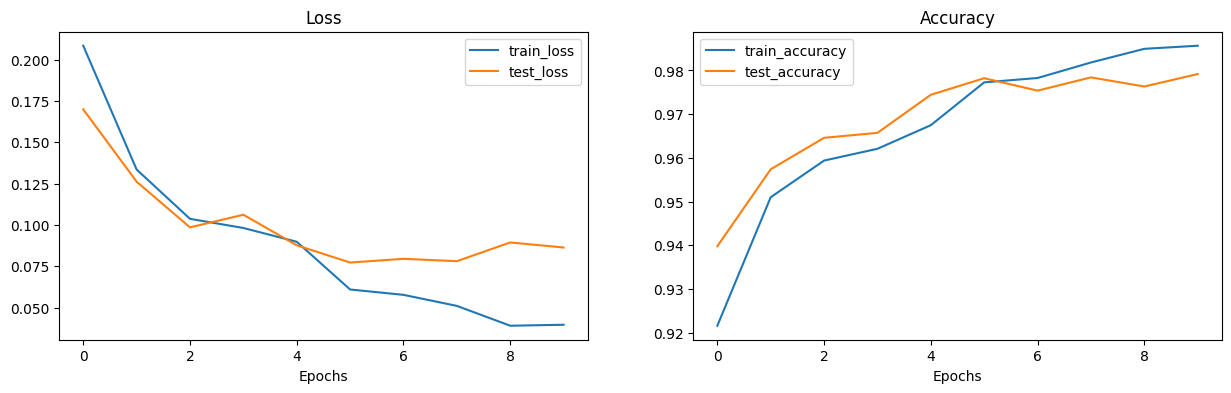

In [41]:
plot_loss_curves(model_results)

## 10. Saving Model

In [44]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save path
MODEL_NAME = "BrainTumorModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/BrainTumorModel.pth


## 11. Loading Model

In [46]:
loaded_model = BrainTumorVGGModel(1, 64, 2).to('cpu')
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")

Loaded model:
BrainTumorVGGModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 12

## 12. Making Predictions on Loaded Model

In [47]:
def make_predictions(model, data, device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim = 0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [61]:
import random
# random.seed(42)

test_samples = []
test_labels = []
# test_targets_tensor = torch.tensor(test_data.targets)
for sample, label in random.sample(list(test_data), k = 28):
  test_samples.append(sample)
  test_labels.append(label)

In [62]:
test_samples[0].shape

torch.Size([1, 224, 224])

In [63]:
loaded_pred_probs = make_predictions(loaded_model,
                                     test_samples,
                                     device)

loaded_pred_classes = loaded_pred_probs.argmax(dim = 1)

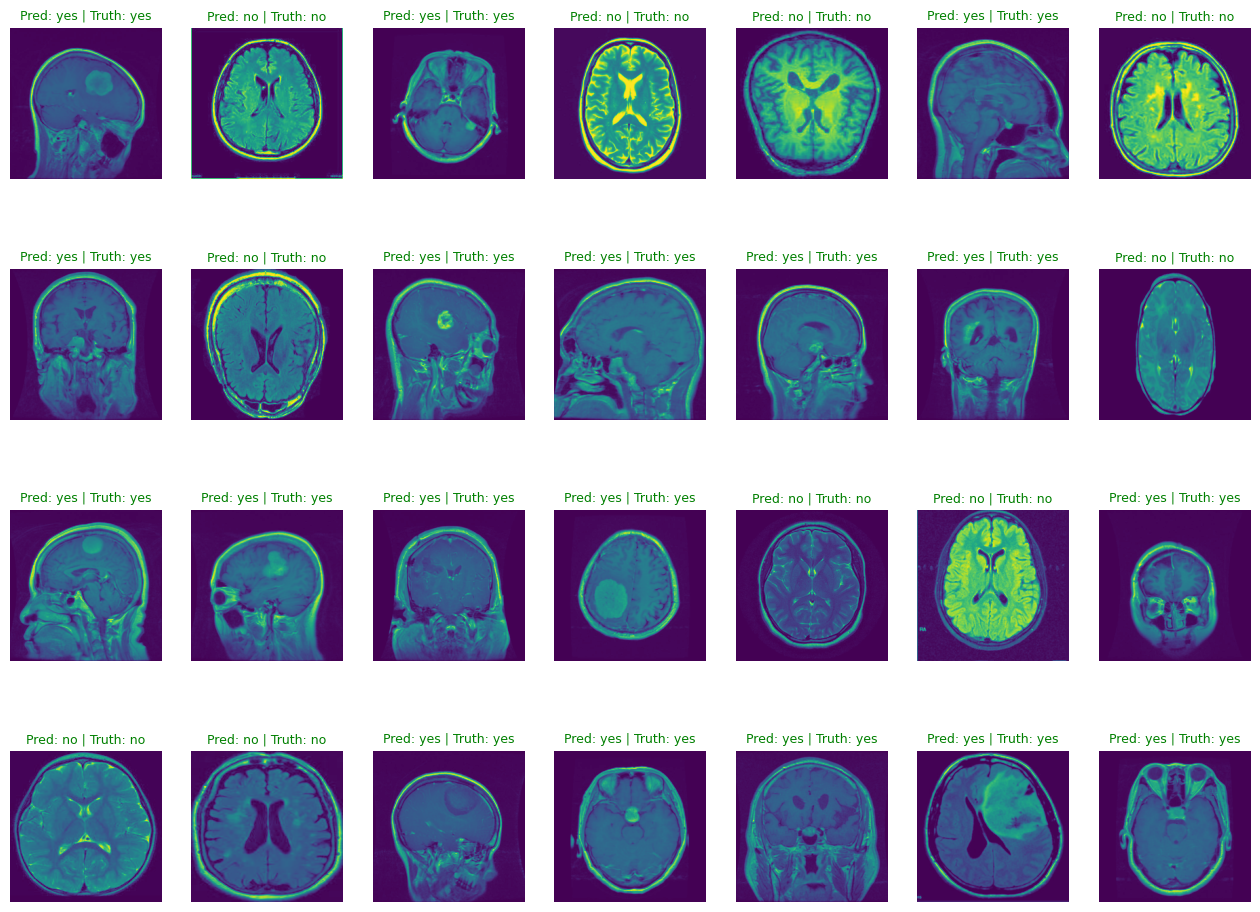

In [65]:
plt.figure(figsize=(16, 12))
nrows, ncols = 4, 7

for i, sample in enumerate(test_samples):
  class_name = np.array(['no', 'yes'])
  plt.subplot(nrows, ncols, i + 1)
  normalized_sample = sample.permute(1, 2, 0).numpy()
  # normalized_sample = normalized_sample / 255.0
  plt.imshow(normalized_sample)

  pred_label = class_name[loaded_pred_classes[i]]
  truth_label = class_name[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label == truth_label:
      plt.title(title_text, fontsize=9, c="g")
  else:
      plt.title(title_text, fontsize=9, c="r")

  plt.axis(False);